### Pre-Processing and Exploratory Data Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import warnings
import spacy
import nltk
import regex as re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
from collections import Counter
from string import punctuation
from nltk.tokenize import word_tokenize
warnings.filterwarnings('ignore')
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_imbal_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, recall_score,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import *

%matplotlib inline


In [3]:
# Read df
df = pd.read_csv('/content/drive/MyDrive/AML Project/mbti_1.csv')

# Global Vars
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")
cachedStopWords = stopwords.words("english")
types = df['type'].tolist()
set_types = set([i.lower() for i in types])
print(set_types)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


{'intp', 'enfj', 'isfj', 'isfp', 'entj', 'infj', 'istj', 'entp', 'enfp', 'estp', 'istp', 'esfp', 'estj', 'infp', 'intj', 'esfj'}


#### Text Pre-processing & Cleaning

In [4]:
#function to remove stop words like the, is, a..etc

def remove_stop(row):
  global cachedStopWords
  global set_types

  row = ' '.join([word for word in row.split() if word not in cachedStopWords])
  row = ' '.join([word for word in row.split() if word not in set_types])
  return row

In [5]:
#function to perform lemmatization 

def lemmatize(row):
  doc = nlp(row)
  return ' '.join([token.lemma_ for token in doc])

In [11]:
#function to get the keywords from the posts

def get_keywords(text):
    keywords = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] 
    doc = nlp(text) 
    for token in doc:

        if(token.text in punctuation):
            keywords.append(token.text)

        if(token.pos_ in pos_tag):
            keywords.append(token.text)
    return ' '.join(word for word in keywords)

In [7]:
#remove unwanted spaces

def remove_unwanted_space(text):
    val1 = '.'
    sentences = text.split('.')
    updated_sentences = []
    for sentence in sentences:
        updated_sentences.append(sentence.strip())
    try:
        while True:
            updated_sentences.remove(val1)
    except ValueError:
        pass
    val2 = ''
    try:
        while True:
            updated_sentences.remove(val2)
    except ValueError:
        pass
    updated_text = ". ".join(updated_sentences)
    return updated_text

In [8]:
#main function which peforms all the text pre-processing

def process_text(df):

  df['posts'] = df['posts'].apply(lambda x: x.lower())
  df['posts'] = df['posts'].apply(lambda x: re.sub(r'http\S+', '', x))
  df['posts'] = df['posts'].apply(lambda x: x.replace("'", ""))

  df['posts'] = df['posts'].apply(lambda x: re.sub(r'[^ a-z\.]+', '', x))
  df['posts'] = df['posts'].apply(lambda x: remove_stop(x))
  df['posts'] = df['posts'].apply(lambda x: lemmatize(x))
  df['posts'] = df['posts'].apply(lambda x: get_keywords(x))
  df['posts'] = df['posts'].apply(lambda x: remove_unwanted_space(x))
  return df

In [9]:
df = process_text(df)

#### Word Vector Embeddings

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
!ls
!pwd
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

--2022-12-04 20:57:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-04 20:57:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-04 20:57:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [14]:
#Functions to convert words into vectors

def do_embedding(row):
  vector_list = []
  for word in row:
    try:
      vector_list.append(embeddings_index[word])
    except:
      pass
  return vector_list

def word_embeddings(df):
  df['vectors'] = df['posts'].apply(lambda x: do_embedding(x))
  return df

In [15]:
# Save df
vectorized_df = word_embeddings(df)

In [16]:
print(len(df), len(vectorized_df))
vectorized_df

8675 8675


type                                              posts  \
0     INFJ  moment sportscenter top prankswhat lifechangin...   
1     ENTP  lack post alarming. sex bore position. example...   
2     INTP  good course blessing positive good friend amaz...   
3     INTJ  dear conversation day. esoteric gabbing nature...   
4     ENTJ  silly misconception. approach key unlocking en...   
...    ...                                                ...   
8670  ISFP  cat fi dom reason. website neo nazis perc. im ...   
8671  ENFP  thread someplace hereooop hard movie watch thr...   
8672  INTP  many question thing. purple pill. win lottery ...   
8673  INFP  conflict right child. maternal instinct. none ...   
8674  INFP  personalitycafe change bit good. doctor world ...   

                                                vectors  
0     [[0.29492, 0.56874, -0.20245, 0.50244, -0.6829...  
1     [[-0.45433, 1.0234, 0.024278, -0.086367, -0.69...  
2     [[-0.37628, 0.37102, 0.32594, -0.085084, -0.55...  
3     [[-0.91091, 0.50459, 0.058175, -0.78618, 0.088...  
4     [[0.13739, 0.77891, 0.80054, 0.13819, -0.49792...  
...                                                 ...  
8670  [[-0.11752, 0.97272, -0.29021, 0.25914, -0.426...  
8671  [[0.13482, 0.40224, -0.42266, -0.055631, -0.55...  
8672  [[0.29492, 0.56874, -0.20245, 0.50244, -0.6829...  
8673  [[-0.11752, 0.97272, -0.29021, 0.25914, -0.426...  
8674  [[-0.6517, 0.80484, 0.048731, 0.37962, -1.1151...  

[8675 rows x 3 columns]

In [18]:
df = vectorized_df

#### EDA

In [19]:
data = vectorized_df

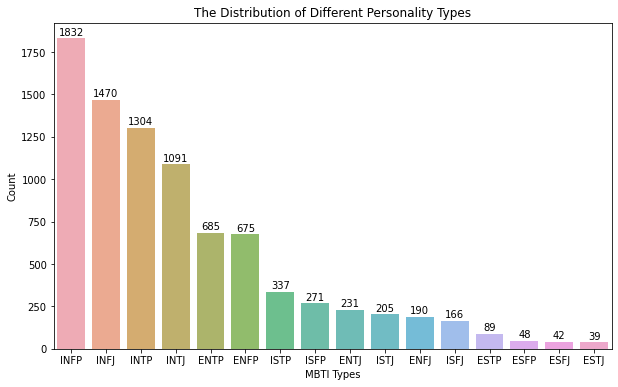

In [20]:
x = data.type.value_counts()
plt.figure(figsize=(10,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('The Distribution of Different Personality Types')
plt.ylabel('Count')
plt.xlabel('MBTI Types')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

In [23]:
#calculating the polarity scores of every post to understand sentiment

data['polarity'] = data['posts'].map(lambda x:TextBlob(x).sentiment.polarity)

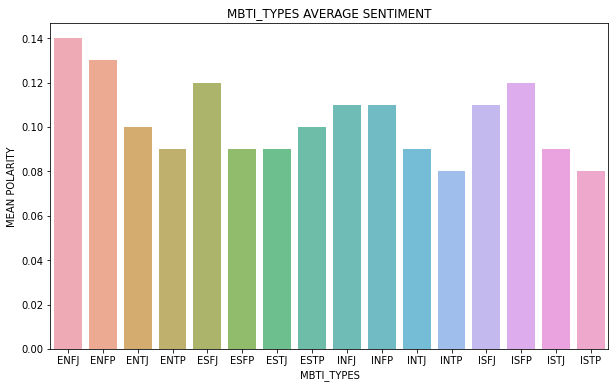

In [24]:
x = round(data.groupby('type')['polarity'].mean(), 2)
plt.figure(figsize=(10,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("MBTI_TYPES AVERAGE SENTIMENT")
plt.ylabel('MEAN POLARITY')
plt.xlabel('MBTI_TYPES')
plt.show()

In [25]:
#calculating the subjectivity scores of every post to understand the difference between fact/opinion

data['subjectivity'] = data['posts'].map(lambda x:TextBlob(x).sentiment.subjectivity)

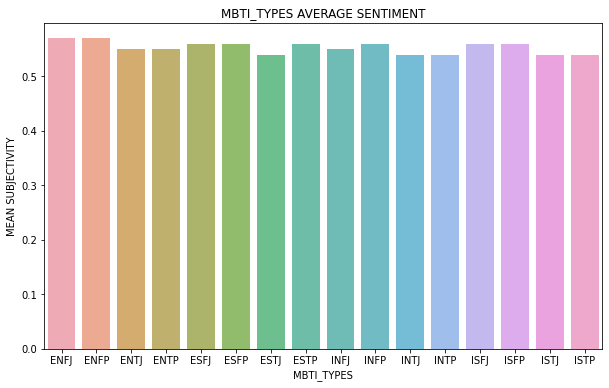

In [26]:
x = round(data.groupby('type')['subjectivity'].mean(), 2)
plt.figure(figsize=(10,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("MBTI_TYPES AVERAGE SENTIMENT")
plt.ylabel('MEAN SUBJECTIVITY')
plt.xlabel('MBTI_TYPES')
plt.show()

In [27]:
def generate_wordcloud(text, title):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize = 40)
    plt.show()

In [28]:
df_by_personality = data.groupby("type")['posts'].apply(' '.join).reset_index()

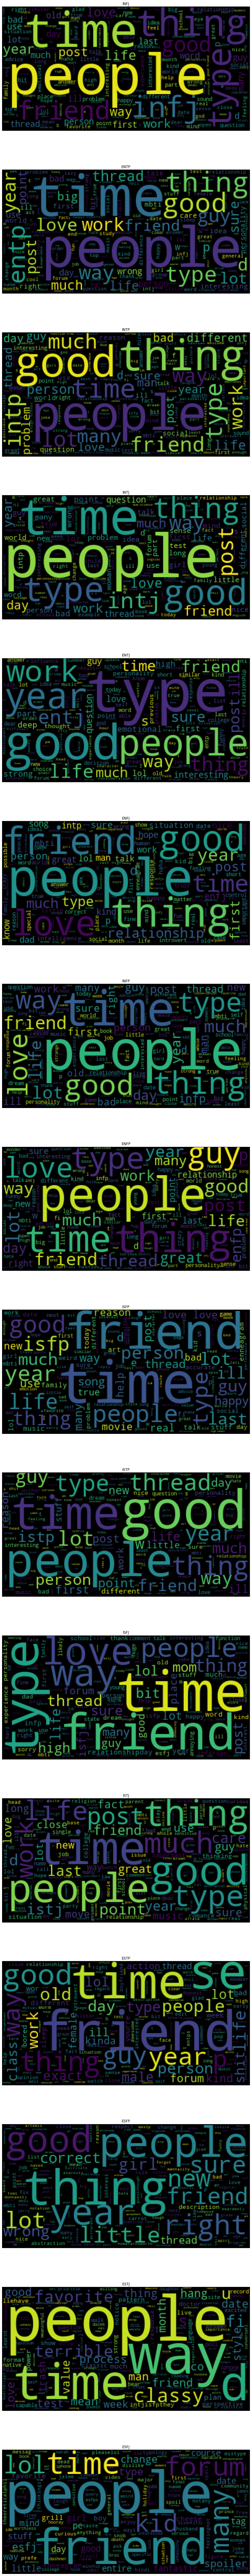

In [29]:
#Generating word clouds and histograms to understand the most commonly used words for each personality type

fig, ax = plt.subplots(len(data['type'].unique()), sharex=True, figsize=(15,10*len(data['type'].unique())))

k = 0
for i in data['type'].unique():
    df_4 = data[data['type'] == i]
    wordcloud = WordCloud().generate(df_4['posts'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1

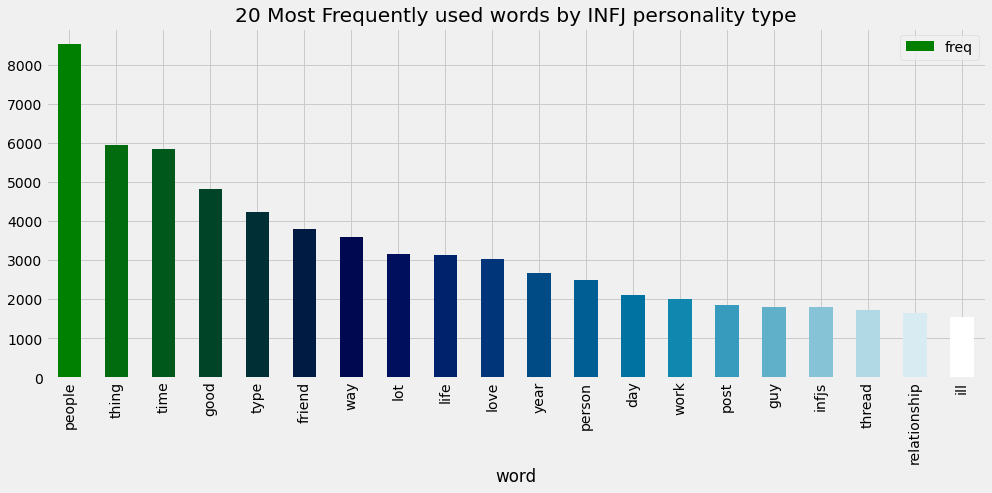

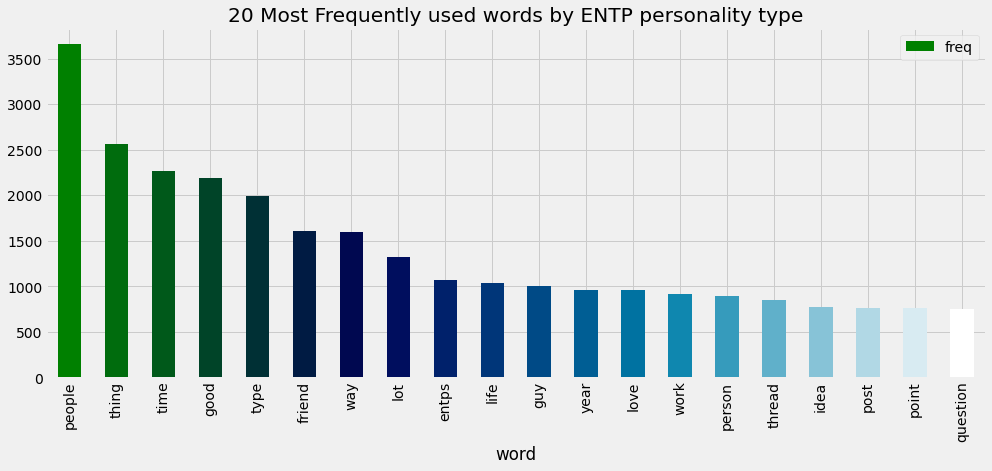

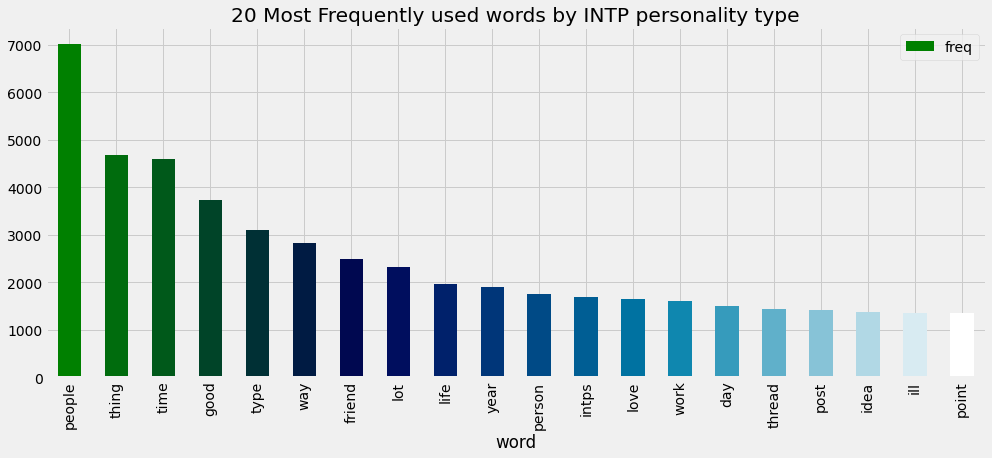

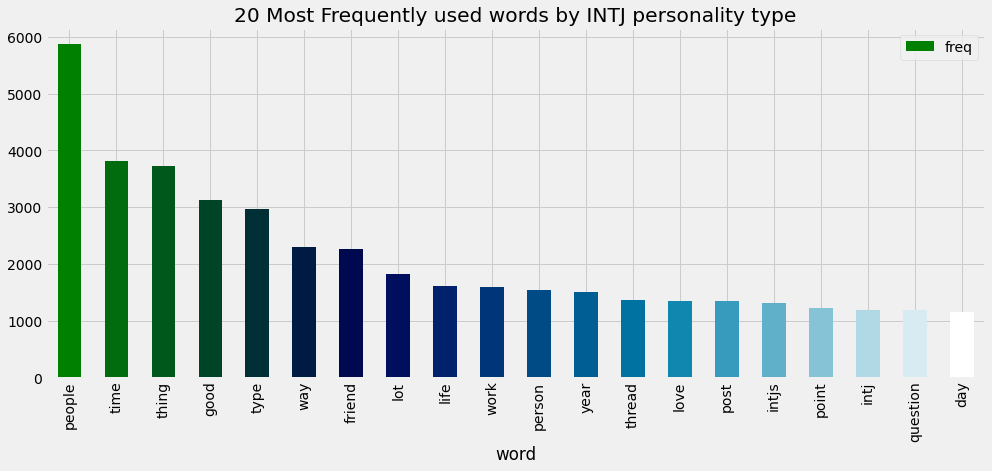

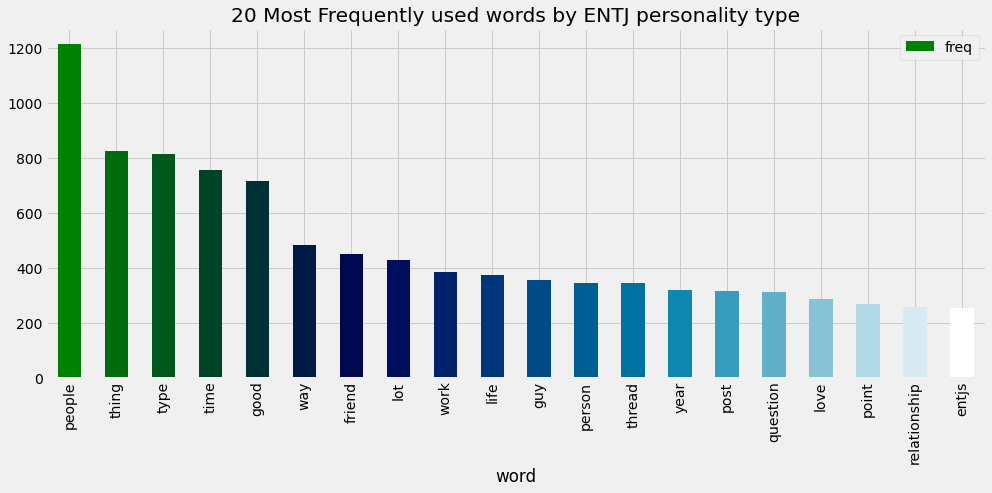

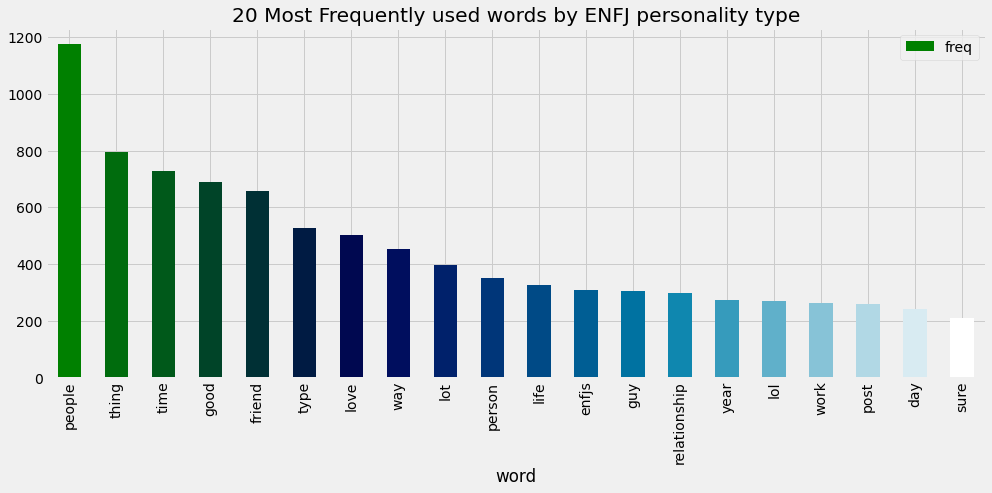

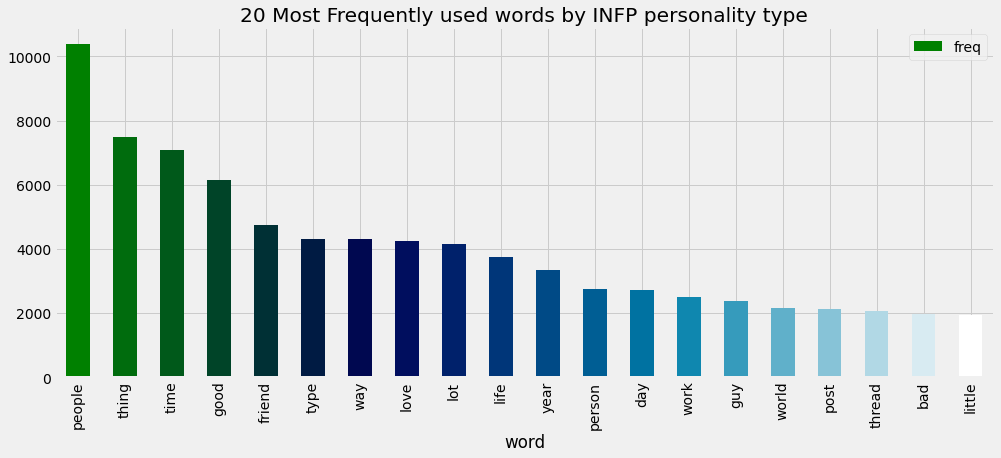

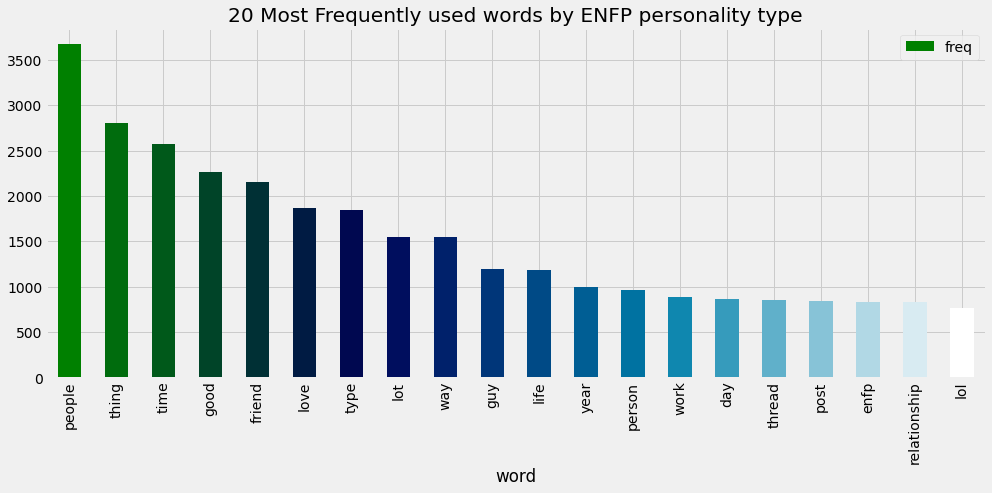

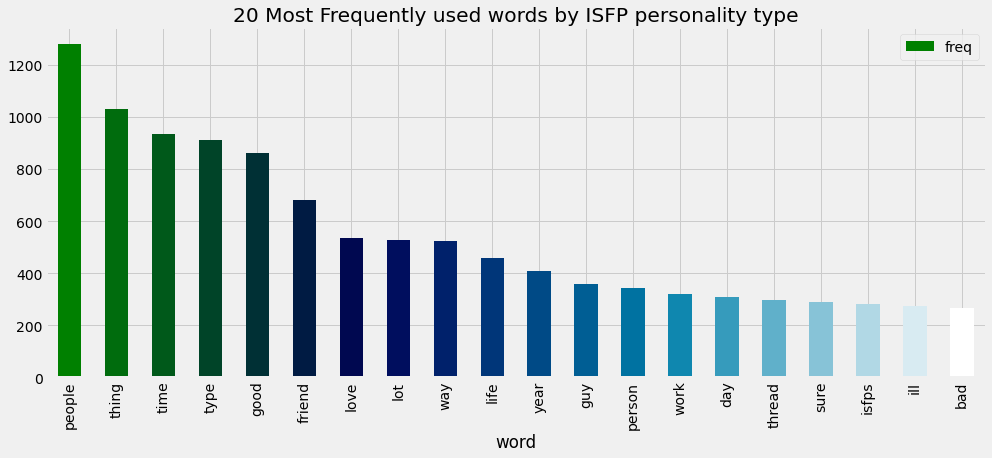

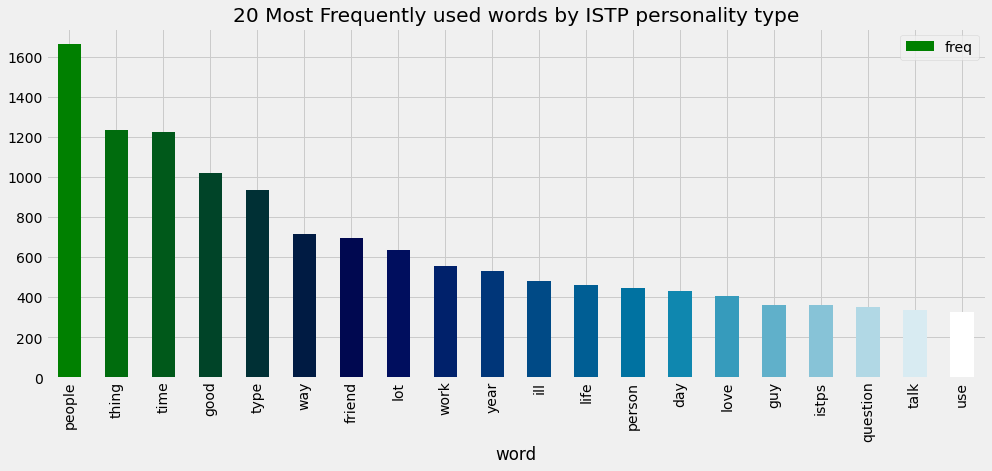

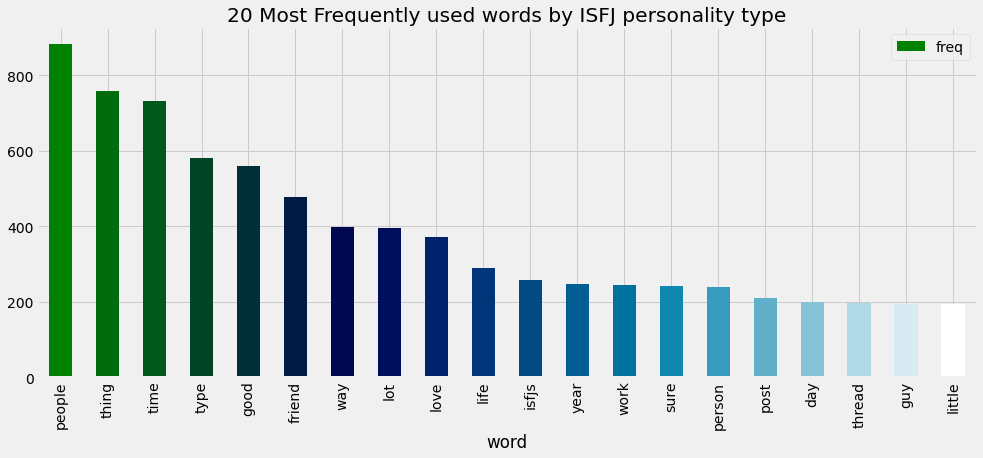

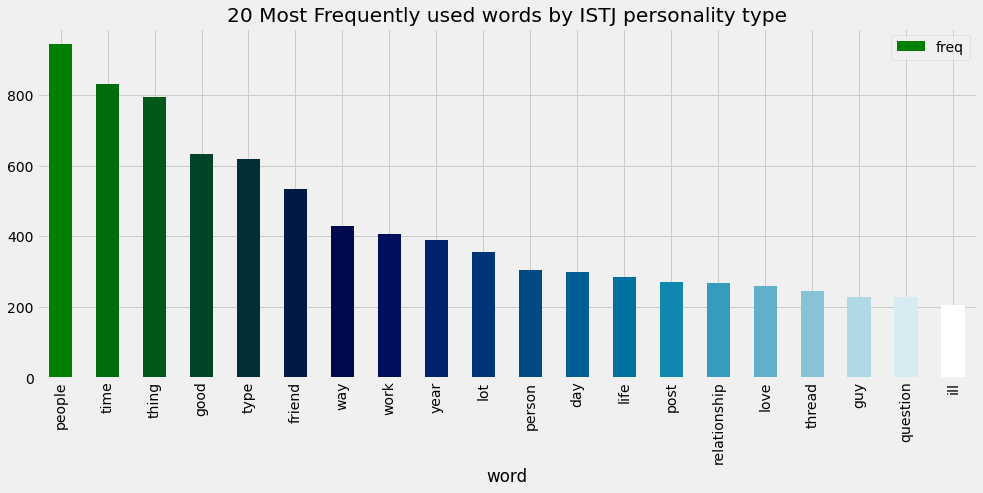

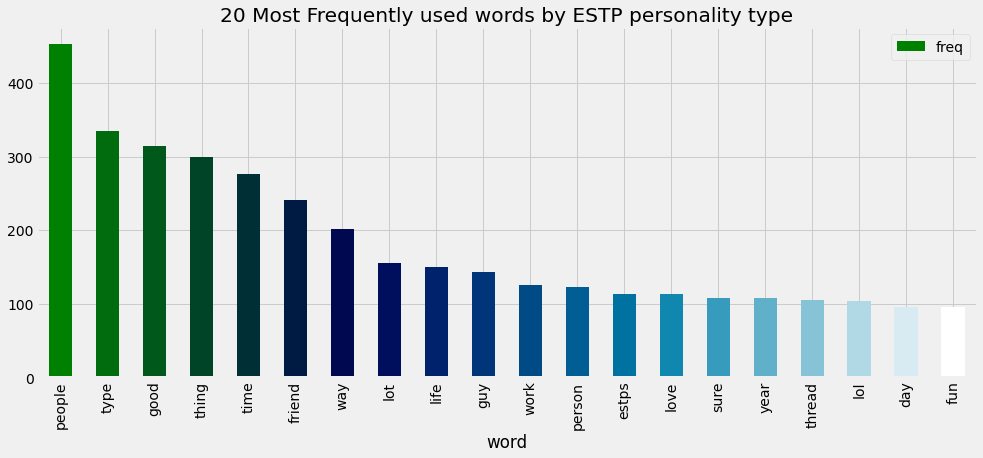

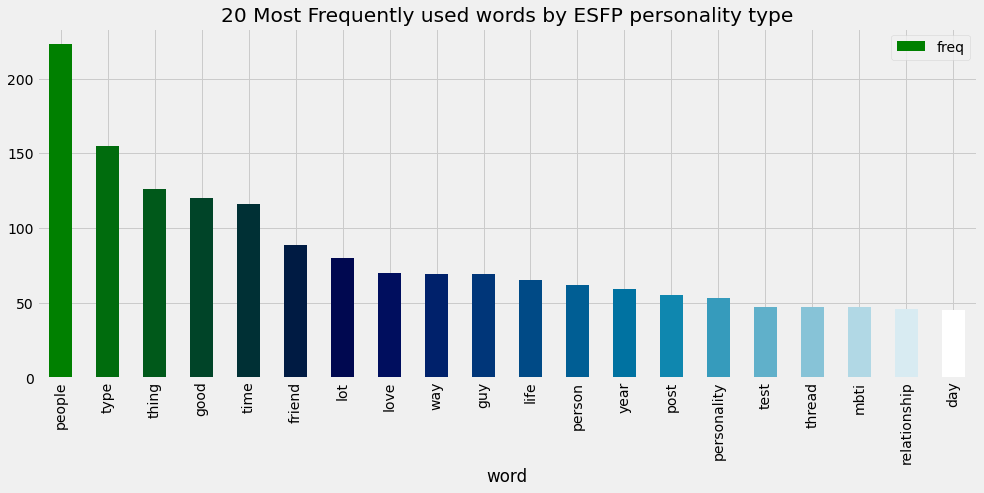

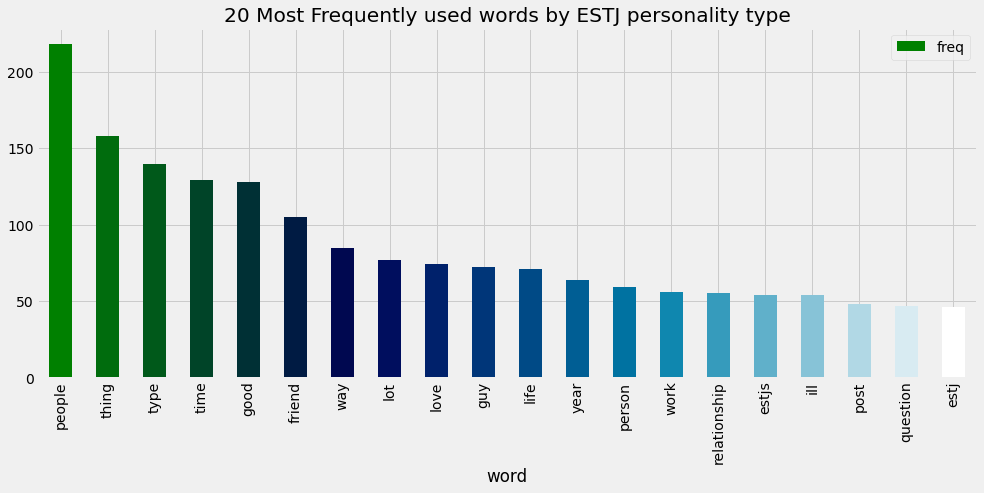

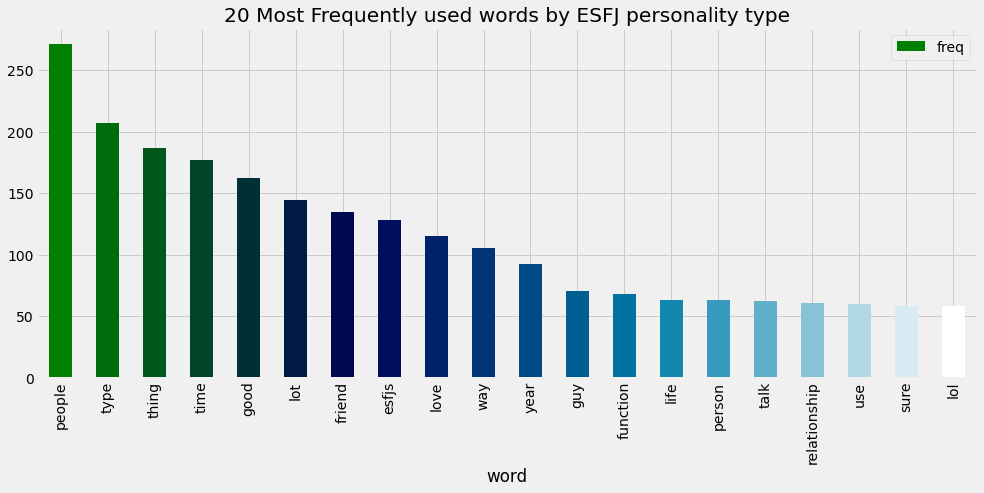

In [30]:
for i in data['type'].unique():
    cv = CountVectorizer(stop_words = 'english')
    words = cv.fit_transform(data[data['type'] == i].posts)
    sum_words = words.sum(axis=0)


    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

    plt.style.use('fivethirtyeight')
    color = plt.cm.ocean(np.linspace(0, 1, 20))
    frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
    plt.title("20 Most Frequently used words by {} personality type".format(i))
    plt.show()

In [31]:
px.pie(data,names='type',title='PERSONALITY TYPE',hole=0.3)

In [32]:
data['word_count'] = data['posts'].apply(lambda x: len(x.split()))
data['char_count'] = data['posts'].apply(len)

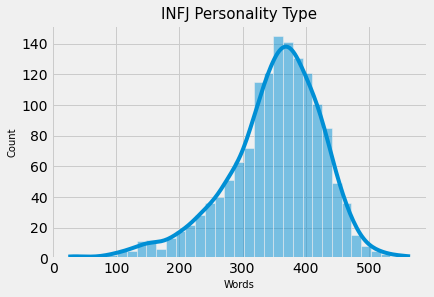

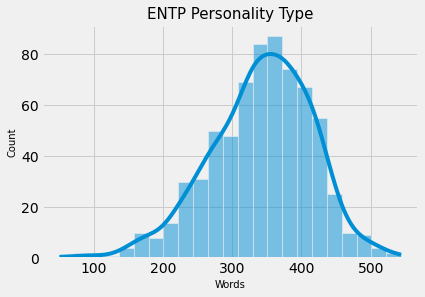

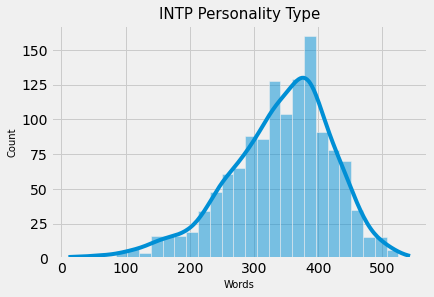

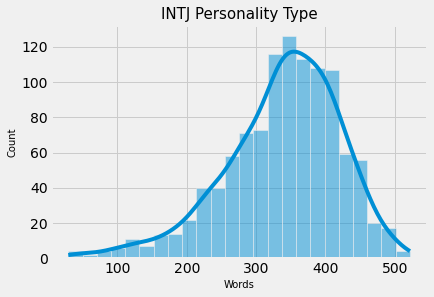

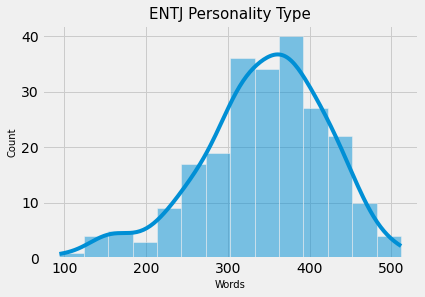

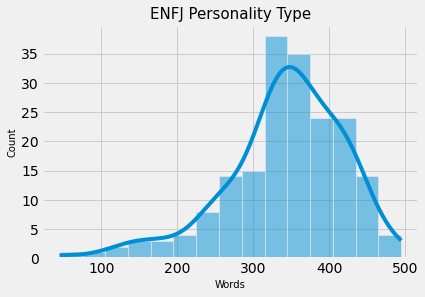

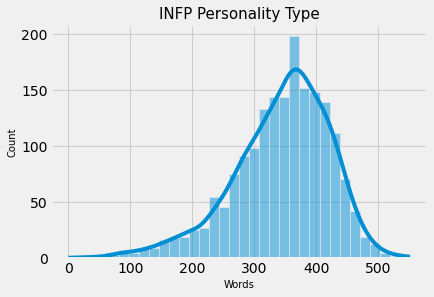

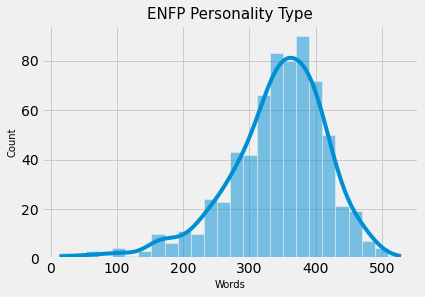

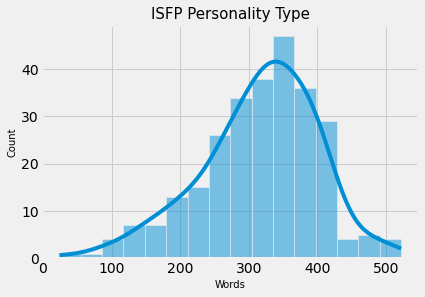

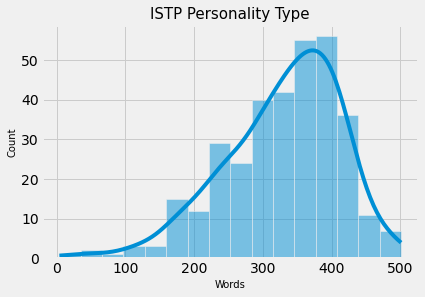

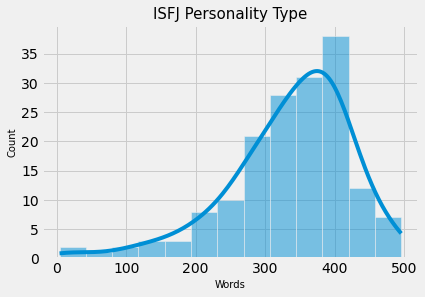

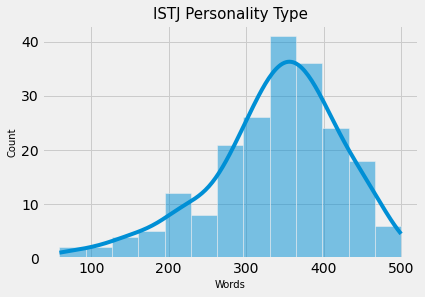

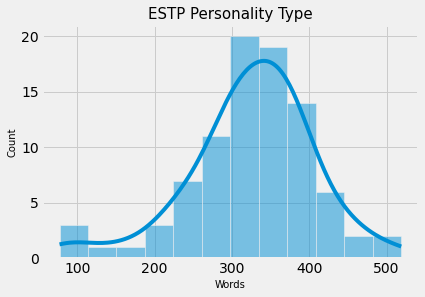

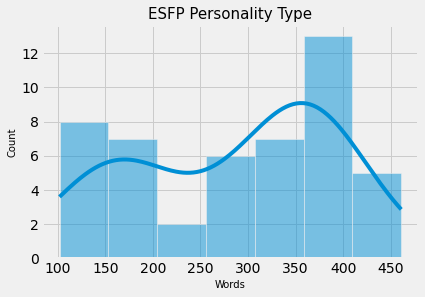

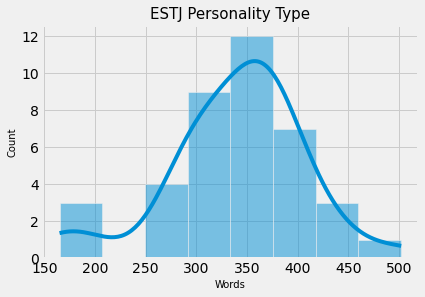

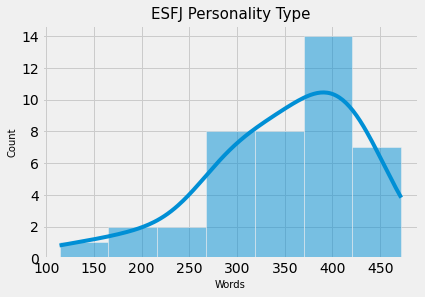

In [33]:
#Understanding the distribution of Word counts for each personality type

for i in data['type'].unique():
    sns.histplot(data=data[data['type'] == i]['word_count'], kde=True)
    plt.title("{} Personality Type".format(i), fontsize=15)
    plt.xlabel('Words', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.show()

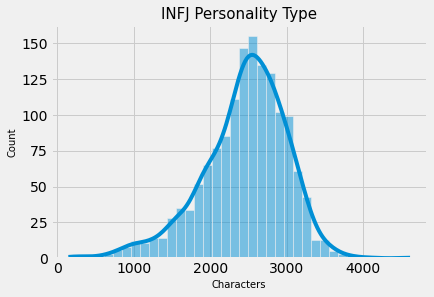

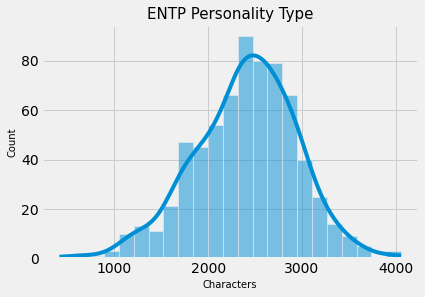

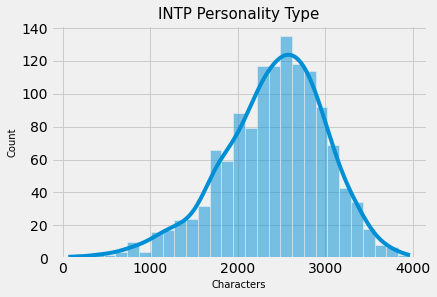

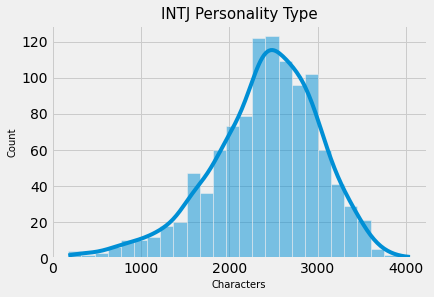

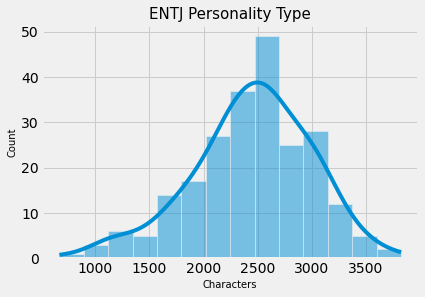

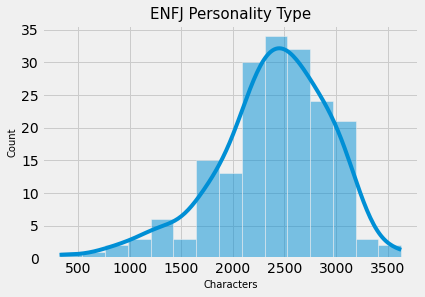

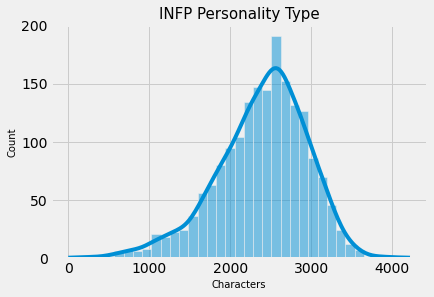

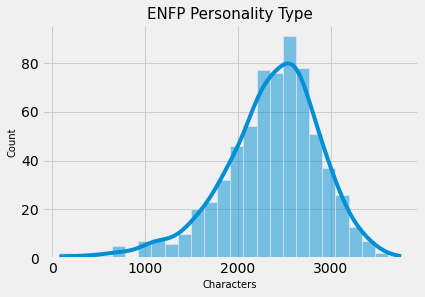

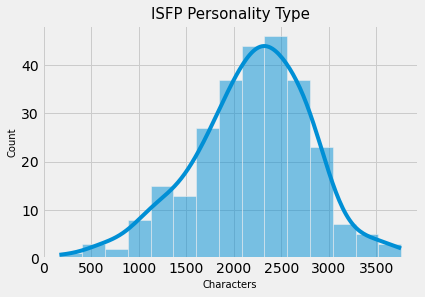

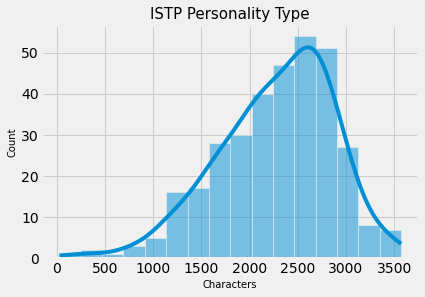

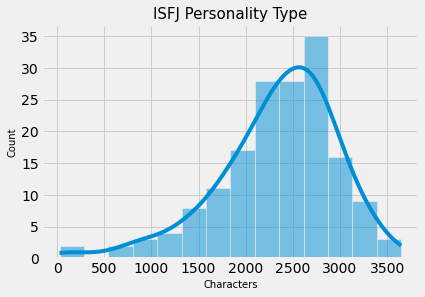

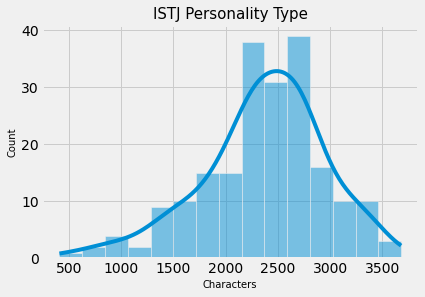

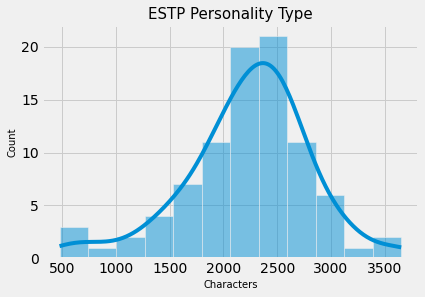

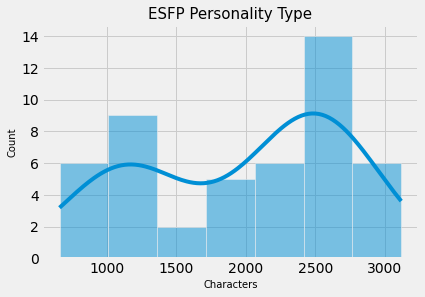

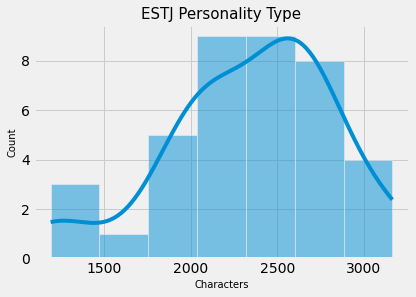

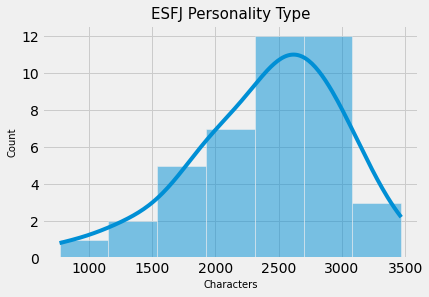

In [34]:
#Understanding the distribution of Character counts for each personality type

for i in data['type'].unique():
    sns.histplot(data=data[data['type'] == i]['char_count'], kde=True)
    plt.title("{} Personality Type".format(i), fontsize=15)
    plt.xlabel('Characters', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.show()

### Split data by categories

In [35]:
# Get average of vectors
df1 = pd.DataFrame([],columns=range(100))
for i in tqdm(range(len(df))):
    vec = sum(df['vectors'][i])/len(df['vectors'][1])
    df1.loc[len(df1)] = vec

  0%|          | 0/8675 [00:00<?, ?it/s]

In [36]:
df1['type'] = df['type']

In [37]:
display(df1)

0         1         2         3         4         5         6  \
0    -0.209376  0.198854  0.056219 -0.085437 -0.194152  0.085088  0.143819   
1    -0.361201  0.379274  0.118784 -0.133162 -0.385487  0.121015  0.249944   
2    -0.292335  0.288878  0.102278 -0.116338 -0.282279  0.101500  0.188891   
3    -0.318508  0.332027  0.115262 -0.138126 -0.339136  0.126303  0.222977   
4    -0.331746  0.340676  0.107578 -0.137671 -0.359856  0.116754  0.237006   
...        ...       ...       ...       ...       ...       ...       ...   
8670 -0.247700  0.268816  0.084432 -0.099864 -0.275837  0.096442  0.175194   
8671 -0.420970  0.374257  0.130425 -0.155434 -0.380822  0.151617  0.272093   
8672 -0.355597  0.342990  0.119931 -0.139155 -0.340479  0.129696  0.238590   
8673 -0.460168  0.445299  0.137463 -0.184071 -0.455202  0.175211  0.311825   
8674 -0.371035  0.334140  0.096671 -0.154120 -0.338814  0.119962  0.235857   

             7         8         9  ...        91        92        93  \
0     0.097970 -0.229019  0.098643  ...  0.250383  0.195343  0.252029   
1     0.183359 -0.400977  0.177658  ...  0.423233  0.311505  0.420498   
2     0.134673 -0.329650  0.144942  ...  0.344705  0.252406  0.348347   
3     0.166778 -0.336413  0.153932  ...  0.363218  0.286102  0.376946   
4     0.172544 -0.363693  0.155316  ...  0.378910  0.299281  0.402857   
...        ...       ...       ...  ...       ...       ...       ...   
8670  0.134008 -0.280876  0.123045  ...  0.314773  0.236080  0.299501   
8671  0.179081 -0.418315  0.197848  ...  0.487675  0.360578  0.481101   
8672  0.177745 -0.358638  0.177998  ...  0.394450  0.292837  0.406758   
8673  0.222498 -0.501991  0.226518  ...  0.533003  0.402545  0.544176   
8674  0.172187 -0.388100  0.160066  ...  0.388405  0.307074  0.425094   

            94        95        96        97        98        99  type  
0    -0.029919 -0.023972 -0.048325 -0.315152  0.112291 -0.086202  INFJ  
1    -0.053132 -0.063658 -0.073184 -0.561471  0.213000 -0.138010  ENTP  
2    -0.046779 -0.040439 -0.040919 -0.442984  0.155134 -0.109500  INTP  
3    -0.066860 -0.045982 -0.075894 -0.501995  0.188028 -0.108340  INTJ  
4    -0.061917 -0.049199 -0.078518 -0.526566  0.177255 -0.119679  ENTJ  
...        ...       ...       ...       ...       ...       ...   ...  
8670 -0.037386 -0.047437 -0.059379 -0.408427  0.146552 -0.088635  ISFP  
8671 -0.051194 -0.056815 -0.055378 -0.618139  0.201325 -0.156850  ENFP  
8672 -0.047173 -0.063197 -0.081574 -0.526089  0.222697 -0.133529  INTP  
8673 -0.073735 -0.084394 -0.095109 -0.706582  0.251552 -0.169031  INFP  
8674 -0.055019 -0.057566 -0.055664 -0.532284  0.180033 -0.126351  INFP  

[8675 rows x 101 columns]

In [38]:
### SPLIT BY CATEGORIES
ie = ['I', 'E']
sn = ['S', 'N']
tf = ['T', 'F']
jp = ['J', 'P']

In [39]:
print(len(df1))

iedf = df1.copy()
iedf['type'] = df1['type'].apply(lambda x: [i for i in x if i in ie][0])


sndf = df1.copy()
sndf['type'] = df1['type'].apply(lambda x: [i for i in x if i in sn][0])


tfdf = df1.copy()
tfdf['type'] = df1['type'].apply(lambda x: [i for i in x if i in tf][0])


jpdf = df1.copy()
jpdf['type'] = df1['type'].apply(lambda x: [i for i in x if i in jp][0])

8675


In [40]:
# Example Output
jpdf.head(3)

0         1         2         3         4         5         6  \
0 -0.209376  0.198854  0.056219 -0.085437 -0.194152  0.085088  0.143819   
1 -0.361201  0.379274  0.118784 -0.133162 -0.385487  0.121015  0.249944   
2 -0.292335  0.288878  0.102278 -0.116338 -0.282279  0.101500  0.188891   

          7         8         9  ...        91        92        93        94  \
0  0.097970 -0.229019  0.098643  ...  0.250383  0.195343  0.252029 -0.029919   
1  0.183359 -0.400977  0.177658  ...  0.423233  0.311505  0.420498 -0.053132   
2  0.134673 -0.329650  0.144942  ...  0.344705  0.252406  0.348347 -0.046779   

         95        96        97        98        99  type  
0 -0.023972 -0.048325 -0.315152  0.112291 -0.086202     J  
1 -0.063658 -0.073184 -0.561471  0.213000 -0.138010     P  
2 -0.040439 -0.040919 -0.442984  0.155134 -0.109500     P  

[3 rows x 101 columns]

In [41]:
# Convert chars to 1 or 0 to allow for classification
iedf['type'] = iedf['type'].replace(list(set(iedf['type'])),range(len(list(set(iedf['type'])))))
sndf['type'] = sndf['type'].replace(list(set(sndf['type'])),range(len(list(set(sndf['type'])))))
tfdf['type'] = tfdf['type'].replace(list(set(tfdf['type'])),range(len(list(set(tfdf['type'])))))
jpdf['type'] = jpdf['type'].replace(list(set(jpdf['type'])),range(len(list(set(jpdf['type'])))))

In [42]:
iedf.head(3)

0         1         2         3         4         5         6  \
0 -0.209376  0.198854  0.056219 -0.085437 -0.194152  0.085088  0.143819   
1 -0.361201  0.379274  0.118784 -0.133162 -0.385487  0.121015  0.249944   
2 -0.292335  0.288878  0.102278 -0.116338 -0.282279  0.101500  0.188891   

          7         8         9  ...        91        92        93        94  \
0  0.097970 -0.229019  0.098643  ...  0.250383  0.195343  0.252029 -0.029919   
1  0.183359 -0.400977  0.177658  ...  0.423233  0.311505  0.420498 -0.053132   
2  0.134673 -0.329650  0.144942  ...  0.344705  0.252406  0.348347 -0.046779   

         95        96        97        98        99  type  
0 -0.023972 -0.048325 -0.315152  0.112291 -0.086202     1  
1 -0.063658 -0.073184 -0.561471  0.213000 -0.138010     0  
2 -0.040439 -0.040919 -0.442984  0.155134 -0.109500     1  

[3 rows x 101 columns]

In [43]:
sndf.head(3)

0         1         2         3         4         5         6  \
0 -0.209376  0.198854  0.056219 -0.085437 -0.194152  0.085088  0.143819   
1 -0.361201  0.379274  0.118784 -0.133162 -0.385487  0.121015  0.249944   
2 -0.292335  0.288878  0.102278 -0.116338 -0.282279  0.101500  0.188891   

          7         8         9  ...        91        92        93        94  \
0  0.097970 -0.229019  0.098643  ...  0.250383  0.195343  0.252029 -0.029919   
1  0.183359 -0.400977  0.177658  ...  0.423233  0.311505  0.420498 -0.053132   
2  0.134673 -0.329650  0.144942  ...  0.344705  0.252406  0.348347 -0.046779   

         95        96        97        98        99  type  
0 -0.023972 -0.048325 -0.315152  0.112291 -0.086202     0  
1 -0.063658 -0.073184 -0.561471  0.213000 -0.138010     0  
2 -0.040439 -0.040919 -0.442984  0.155134 -0.109500     0  

[3 rows x 101 columns]

In [44]:
tfdf.head(3)

0         1         2         3         4         5         6  \
0 -0.209376  0.198854  0.056219 -0.085437 -0.194152  0.085088  0.143819   
1 -0.361201  0.379274  0.118784 -0.133162 -0.385487  0.121015  0.249944   
2 -0.292335  0.288878  0.102278 -0.116338 -0.282279  0.101500  0.188891   

          7         8         9  ...        91        92        93        94  \
0  0.097970 -0.229019  0.098643  ...  0.250383  0.195343  0.252029 -0.029919   
1  0.183359 -0.400977  0.177658  ...  0.423233  0.311505  0.420498 -0.053132   
2  0.134673 -0.329650  0.144942  ...  0.344705  0.252406  0.348347 -0.046779   

         95        96        97        98        99  type  
0 -0.023972 -0.048325 -0.315152  0.112291 -0.086202     0  
1 -0.063658 -0.073184 -0.561471  0.213000 -0.138010     1  
2 -0.040439 -0.040919 -0.442984  0.155134 -0.109500     1  

[3 rows x 101 columns]

In [45]:
jpdf.head(3)

0         1         2         3         4         5         6  \
0 -0.209376  0.198854  0.056219 -0.085437 -0.194152  0.085088  0.143819   
1 -0.361201  0.379274  0.118784 -0.133162 -0.385487  0.121015  0.249944   
2 -0.292335  0.288878  0.102278 -0.116338 -0.282279  0.101500  0.188891   

          7         8         9  ...        91        92        93        94  \
0  0.097970 -0.229019  0.098643  ...  0.250383  0.195343  0.252029 -0.029919   
1  0.183359 -0.400977  0.177658  ...  0.423233  0.311505  0.420498 -0.053132   
2  0.134673 -0.329650  0.144942  ...  0.344705  0.252406  0.348347 -0.046779   

         95        96        97        98        99  type  
0 -0.023972 -0.048325 -0.315152  0.112291 -0.086202     0  
1 -0.063658 -0.073184 -0.561471  0.213000 -0.138010     1  
2 -0.040439 -0.040919 -0.442984  0.155134 -0.109500     1  

[3 rows x 101 columns]

### Train ML Models

In [46]:
def get_SVC(X_dev, y_dev, X_test, y_test):
  
  svc_model1=LinearSVC(loss='hinge',  random_state=42)
  smote = SMOTE(random_state=42)
  smote.fit_resample(X_dev, y_dev)
  pipe_svc = make_imbal_pipeline(smote, GridSearchCV(LinearSVC(random_state = 42),
                                  param_grid={'max_iter': [25, 50, 100, 150],
                                              'C': [0.01, 0.1, 0.5, 0.7, 1, 3]},
                                  cv=5,
                                  scoring='f1_micro',
                                  refit=True))
    
  results = pipe_svc.fit(X_dev, y_dev)
  preds = pipe_svc.predict(X_test)
  print(f1_score(y_test, preds, average='micro'))
  

  return preds

In [47]:
def get_RF(X_dev, y_dev, X_test, y_test):
  smote = SMOTE(random_state=42)
  smote.fit_resample(X_dev, y_dev)
  pipe_rfc = make_imbal_pipeline(smote, GridSearchCV(RandomForestClassifier(random_state = 42),
                                  param_grid={'ccp_alpha': [0.1, 0.2, 0.3],
                                              'n_estimators': [25, 50, 75],
                                              'max_depth': [3, 5, 7]},
                                  cv = 5,
                                  scoring='f1_micro',
                                  refit = True))
  results = pipe_rfc.fit(X_dev, y_dev)
  preds = pipe_rfc.predict(X_test)
  print(f1_score(y_test, preds, average='micro'))

  
  return preds

In [48]:
def get_HGB(X_dev, y_dev, X_test, y_test):

  smote = SMOTE(random_state=42)
  smote.fit_resample(X_dev, y_dev)
  pipe_hgbc = make_imbal_pipeline(smote, GridSearchCV(HistGradientBoostingClassifier(random_state=33),
                                  param_grid={'learning_rate': [0.1, 0.2, 0.3],
                                              'max_iter': [25, 50, 100],
                                              'max_depth': [3, 5, 7]},
                                  cv=5,
                                  scoring='f1_micro',
                                  refit=True))
    
  results = pipe_hgbc.fit(X_dev, y_dev)
  preds = pipe_hgbc.predict(X_test)
  print(f1_score(y_test, preds, average='micro'))

  X_train, X_calib, y_train, y_calib = train_test_split(X_dev, y_dev, test_size=0.2, random_state=19)

  cal_hgb_platt = CalibratedClassifierCV(pipe_hgbc, cv='prefit', method='sigmoid')
  cal_hgb_platt.fit(X_calib, y_calib)
  
  cal_preds = cal_hgb_platt.predict(X_test)
  print(f1_score(y_test, cal_preds, average='micro'))
  return preds, cal_preds


In [49]:
def get_KNN(X_dev, y_dev, X_test, y_test):
  smote = SMOTE(random_state=42)
  smote.fit_resample(X_dev, y_dev)

  pipe_KNN = make_imbal_pipeline(smote, GridSearchCV(KNeighborsClassifier(n_jobs=-1),
                                  param_grid={'n_neighbors': list(range(1, 31))},
                                  cv = 10,
                                  scoring='f1_micro',
                                  refit = True))

  results = pipe_KNN.fit(X_dev, y_dev)

  preds = pipe_KNN.predict(X_test)
  print(f1_score(y_test, preds, average='micro'))


  return preds

In [50]:
def get_LR(X_dev, y_dev, X_test, y_test):

  smote = SMOTE(random_state=42)
  smote.fit_resample(X_dev, y_dev)
  lr=LogisticRegression(random_state=0)
  solvers = ['newton-cg', 'lbfgs', 'liblinear']
  penalty = ['l2']
  c_values = [100, 10, 1.0, 0.1, 0.01]
  grid = dict(solver=solvers,penalty=penalty,C=c_values)
  cv = 10
  pipe_lr = make_imbal_pipeline(smote,  GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_micro'))  
  results = pipe_lr.fit(X_dev, y_dev)
  preds = pipe_lr.predict(X_test)
  print(f1_score(y_test, preds, average='micro'))
  return preds

In [51]:
def get_NB(X_dev, y_dev, X_test, y_test):

  smote = SMOTE(random_state=42)
  smote.fit_resample(X_dev, y_dev)
  gnb = GaussianNB()
  params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
  pipe_nb = make_imbal_pipeline(smote, GridSearchCV(gnb,
                                  param_grid=params_NB,
                                  cv=5,
                                  scoring='f1_micro',
                                  refit=True))
    
  results = pipe_nb.fit(X_dev, y_dev)
  preds = pipe_nb.predict(X_test)
  print(f1_score(y_test, preds, average='micro'))
  return preds

In [53]:
 # Run Models for each 

char_list = ['IE', 'SN', 'TF', 'JP']

df_li = [iedf, sndf, tfdf, jpdf]
df_dict = dict()

# For each pair of characteristics
for i in range(len(df_li)):

  

  # Get the raw df
  dataframe = df_li[i]

  X = dataframe.drop('type', axis=1)
  y = dataframe['type']

  # First split into dev and test
  X_dev, X_test, y_dev, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    stratify=y,
                                                    random_state = 42)

  # Run Classification Models
  print(char_list[i])
  svc_preds = get_SVC(X_dev, y_dev, X_test, y_test)
  rf_preds = get_RF(X_dev, y_dev, X_test, y_test)
  hgb_preds, cal_hgb_preds = get_HGB(X_dev, y_dev, X_test, y_test)
  KNN_preds = get_KNN(X_dev, y_dev, X_test, y_test)
  lr_preds=get_LR(X_dev, y_dev, X_test, y_test)
  nb_preds=get_NB(X_dev, y_dev, X_test, y_test)
  
  
  # Print Results of Classification models
  
  print("SVC")
  print(classification_report(y_test,svc_preds))
  print("Random Forest")
  print(classification_report(y_test,rf_preds))
  print("HistGradientBoost")
  print(classification_report(y_test,hgb_preds))
  print("CalibratedHistGB")
  print(classification_report(y_test,cal_hgb_preds))
  print('KNN')
  print(classification_report(y_test,KNN_preds))
  print("Logistic Regression")
  print(classification_report(y_test,lr_preds))
  print("Naive Bayes")
  print(classification_report(y_test,nb_preds))
  

IE
0.5846011987090826
0.23052097740894423
0.6371599815583218
0.677731673582296
0.5689257722452743
0.582757030889811
0.43245735361917936
SVC
              precision    recall  f1-score   support

           0       0.28      0.51      0.36       500
           1       0.80      0.61      0.69      1669

    accuracy                           0.58      2169
   macro avg       0.54      0.56      0.53      2169
weighted avg       0.68      0.58      0.62      2169

Random Forest
              precision    recall  f1-score   support

           0       0.23      1.00      0.37       500
           1       0.00      0.00      0.00      1669

    accuracy                           0.23      2169
   macro avg       0.12      0.50      0.19      2169
weighted avg       0.05      0.23      0.09      2169

HistGradientBoost
              precision    recall  f1-score   support

           0       0.26      0.31      0.28       500
           1       0.78      0.74      0.76      1669

    accura

### Train Deep Learning Models: RNN (LSTM)

In [54]:


char_list = ['IE', 'SN', 'TF', 'JP']

df_li = [iedf, sndf, tfdf, jpdf]
df_dict = dict()

# For each pair of characteristics
for i in range(len(df_li)):

  

  # Get the raw df
  dataframe = df_li[i]

  X = dataframe.drop('type', axis=1)
  y = dataframe['type']


  # First split into dev and test
  X_dev, X_test, y_dev, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    stratify=y,
                                                    random_state = 42)
  
  X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    random_state = 42)
  




  model = Sequential()
  model.add(LSTM(100, input_shape=(100,1), return_sequences=True))
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile("adam", "binary_crossentropy", metrics=['accuracy'])
  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20,batch_size=100, verbose=0)

  y_pred = model.predict(X_test, batch_size=64, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)

  print(classification_report(y_test, y_pred_bool))
  print(f1_score(y_test, y_pred_bool, average='micro'))

34/34 [==============================] - 3s 14ms/step
              precision    recall  f1-score   support

           0       0.23      1.00      0.37       500
           1       0.00      0.00      0.00      1669

    accuracy                           0.23      2169
   macro avg       0.12      0.50      0.19      2169
weighted avg       0.05      0.23      0.09      2169

0.23052097740894423
34/34 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1870
           1       0.00      0.00      0.00       299

    accuracy                           0.86      2169
   macro avg       0.43      0.50      0.46      2169
weighted avg       0.74      0.86      0.80      2169

0.8621484555094514
34/34 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1174
           1       0.00      0.00     

**Thank you!**